Sarsa(lamda)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from env import draw_card, step, get_action, cards
from matplotlib import cm
from tqdm import trange, tqdm
from datetime import datetime
import os

np.random.seed(1234567890)

In [2]:
Q = np.random.uniform(-1,1,(21, 10, 2))
N = np.zeros((21,10,2))
Q_star = np.load("MC_Results 2024-07-21 19:26:46.469298/Q_star_MC.npy")

In [3]:
def SarsaLam(ep, lam, n0):
    global Q
    global N
    global Q_star
    mse = []
    for j in range(ep):
        ET = np.zeros((21, 10, 2))
        curr = (np.random.choice(cards), np.random.choice(cards))
        act = get_action(curr[1] - 1, curr[0] - 1, n0, Q, N)
        t = 0
        
        while t == 0:
            curr_n, rew, t = step(curr, act)
            act_n = get_action(curr_n[1] - 1, curr_n[0] - 1, n0, Q, N)
            
            ET[curr[1] - 1][curr[0] - 1][act] += 1
            N[curr[1] - 1][curr[0] - 1][act] += 1
            a = 1/(N[curr[1] - 1][curr[0] - 1][act])
            err = (rew + Q[curr_n[1] - 1][curr_n[0] - 1][act_n] - Q[curr[1] - 1][curr[0] - 1][act])
            Q = Q + a*err*ET
            ET *= lam
            curr = curr_n
            act = act_n
        
        mse.append(np.sum(np.power((Q - Q_star),2))/(21*10*2))
    return np.average(mse)

In [4]:
os.chdir("/home/guest/Desktop/Om/Stuff/Reinforce/")
name = f"SarsaLam {datetime.now()}"
os.mkdir(name)
os.chdir(name)

100%|███████████████████████████████████████████| 11/11 [00:09<00:00,  1.18it/s]


<IPython.core.display.Javascript object>


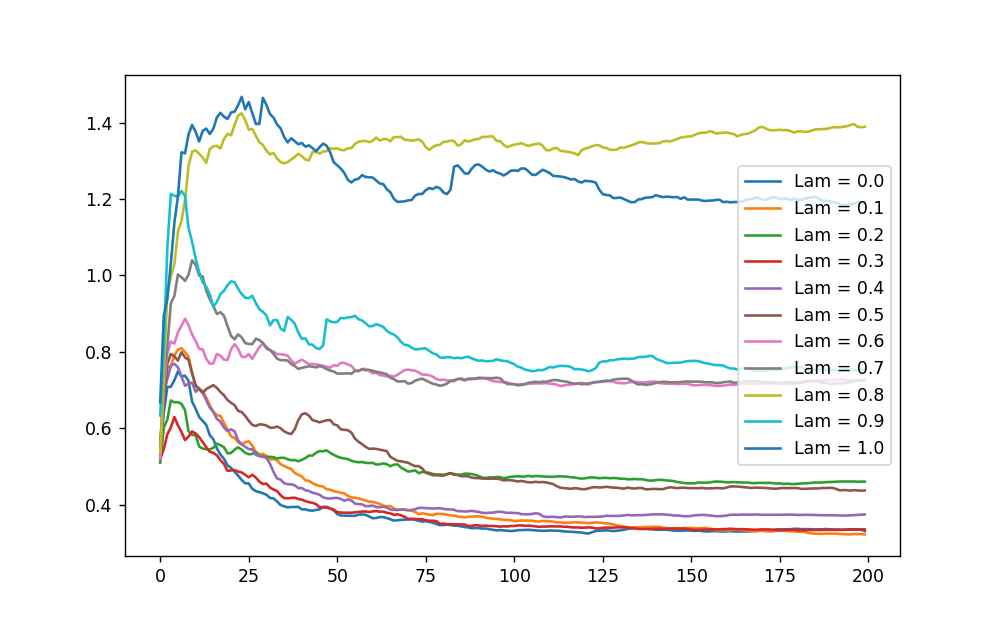

In [5]:
mseLam = []
for lam in tqdm(np.arange(0,1.1,0.1)):
    Q = np.random.uniform(-1,1,(21, 10, 2))
    N = np.zeros((21, 10, 2))
    run = []
    for k in range(200):
        run.append(SarsaLam(100, lam, 150))
    mseLam.append(run)

%matplotlib notebook
plt.figure(figsize=(8,5))
for i,data in enumerate(mseLam):
    plt.plot(range(len(data)), data, label=f"Lam = {i/10}",)
plt.legend()
plt.savefig("Lam Sweep")
plt.show()

In [6]:
def benchmark():
    wins = 0
    for i in range(1000):
        curr = (np.random.choice(cards), np.random.choice(cards))
        act = np.argmax(Q[curr[1]-1][curr[0]-1])
        curr, rew, t = step(curr, act)
        while t == 0:
            act = np.argmax(Q[curr[1]-1][curr[0]-1])
            curr, rew, t = step(curr, act)
        if rew >= 0:
            wins += 1
    return wins

<h1>Lam = 0</h1>

100%|███████████████████████████████████████| 2000/2000 [00:51<00:00, 39.09it/s]


<IPython.core.display.Javascript object>


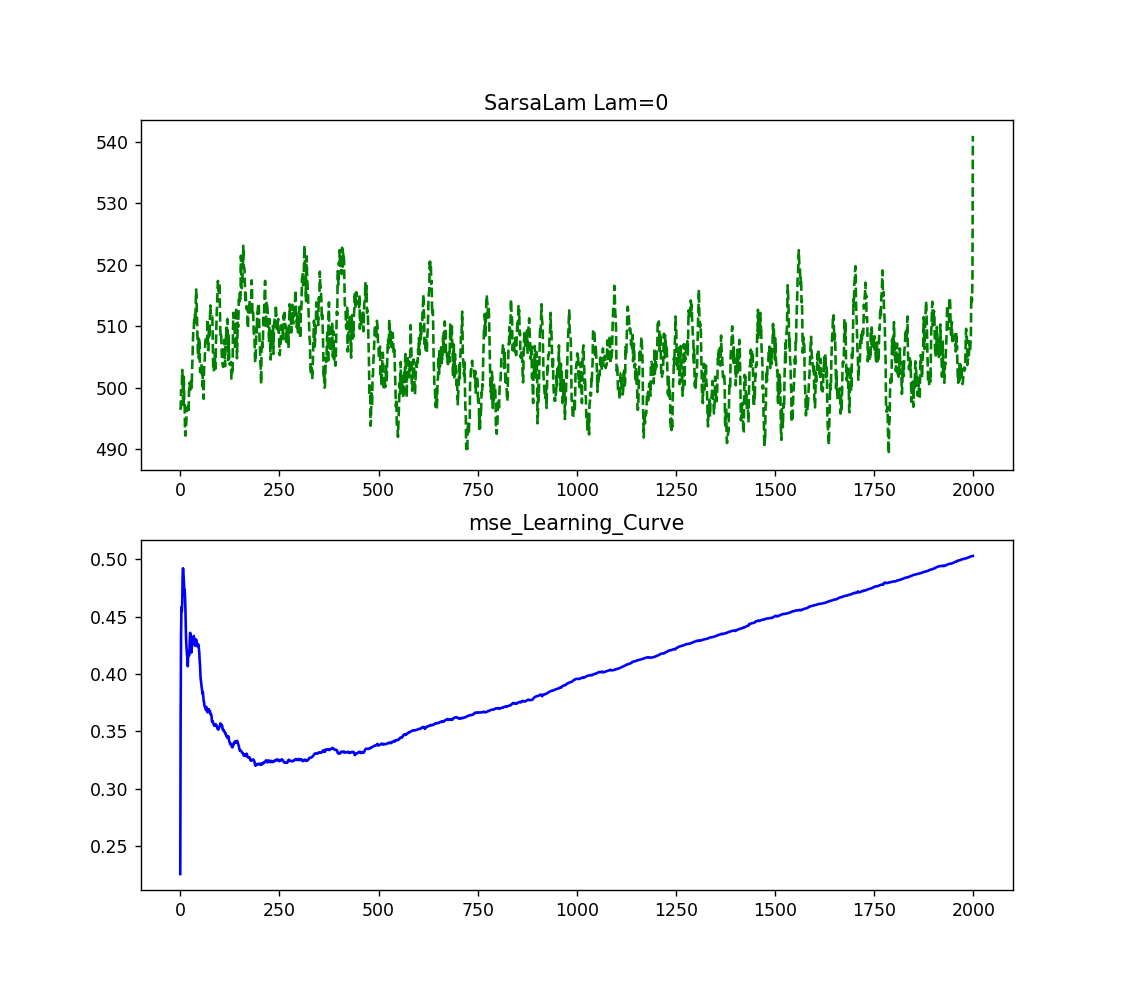

In [7]:
Q = np.zeros((21,10,2))
N = np.zeros((21,10,2))
n = 0
best = 0
win_history = []
mse_history = []
for i in trange(2000):
    mse_history.append(SarsaLam(100, 0, 100))
    n+=1000
    win_history.append(benchmark())
    if np.average(win_history[-10:]) > best:
        np.save("Best_Q_0",Q)
        best_i = i
        best = np.average(win_history[-10:])

rolling_wins =[]
roll = 10
i = 0

for i in range(len(win_history)):
    rolling_wins.append(np.average(win_history[i:i+roll]))
%matplotlib notebook
plt.figure(figsize=(9,8))
plt.subplot(2,1,1)
plt.plot(range(len(rolling_wins)), rolling_wins, 'g--')
plt.title("SarsaLam Lam=0")
plt.subplot(2,1,2)
plt.plot(range(len(mse_history)), mse_history, 'b')
plt.title("mse_Learning_Curve")
plt.savefig("Lam=0")
plt.show()

In [8]:
best_i

322

# Trained Agent Performance

In [9]:
Q = np.load("Best_Q_0.npy")

wins = 0
for i in trange(1_00_000):
    curr = (np.random.choice(cards), np.random.choice(cards))
    act = np.argmax(Q[curr[1]-1][curr[0]-1])
    curr, rew, t = step(curr, act)
    while t == 0:
        act = act = np.argmax(Q[curr[1]-1][curr[0]-1])
        curr, rew, t = step(curr, act)
    if rew >= 0:
        wins += 1
print(wins)

100%|████████████████████████████████| 100000/100000 [00:02<00:00, 46783.11it/s]

51217


<IPython.core.display.Javascript object>


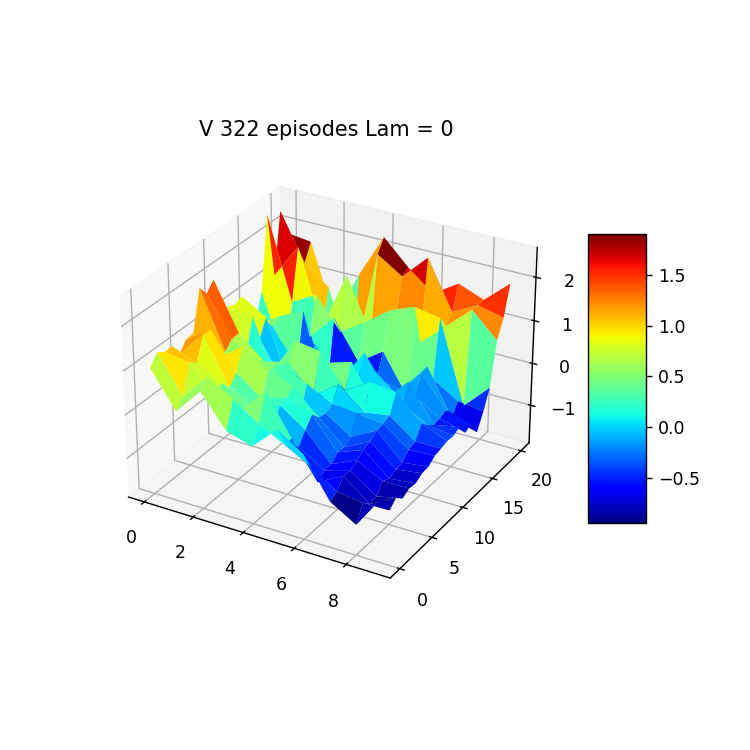

In [10]:
%matplotlib notebook
V = np.zeros((21, 10))
for j in range(21):
    for i in range(10):
        V[j][i] = np.max(Q[j][i])
X, Y = np.meshgrid(range(10), range(21))
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection = '3d')
surf = ax.plot_surface(X, Y, V, cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title(f"V {best_i} episodes Lam = 0")
plt.savefig(f"V {best_i} episodes Lam = 0")
plt.show()

<IPython.core.display.Javascript object>


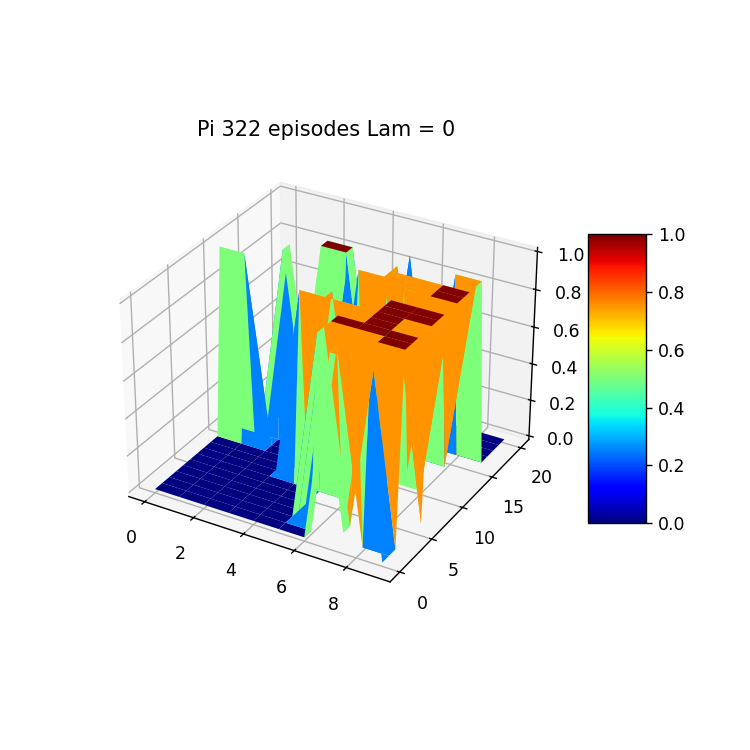

In [11]:
%matplotlib notebook
V = np.zeros((21, 10))
for j in range(21):
    for i in range(10):
        V[j][i] = np.argmax(Q[j][i])
X, Y = np.meshgrid(range(10), range(21))
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection = '3d')
surf = ax.plot_surface(X, Y, V, cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title(f"Pi {best_i} episodes Lam = 0")
plt.savefig(f"Pi {best_i} episodes Lam = 0")
plt.show()

<h1>Lam = 1</h1>

100%|███████████████████████████████████████| 2000/2000 [00:54<00:00, 36.74it/s]


<IPython.core.display.Javascript object>


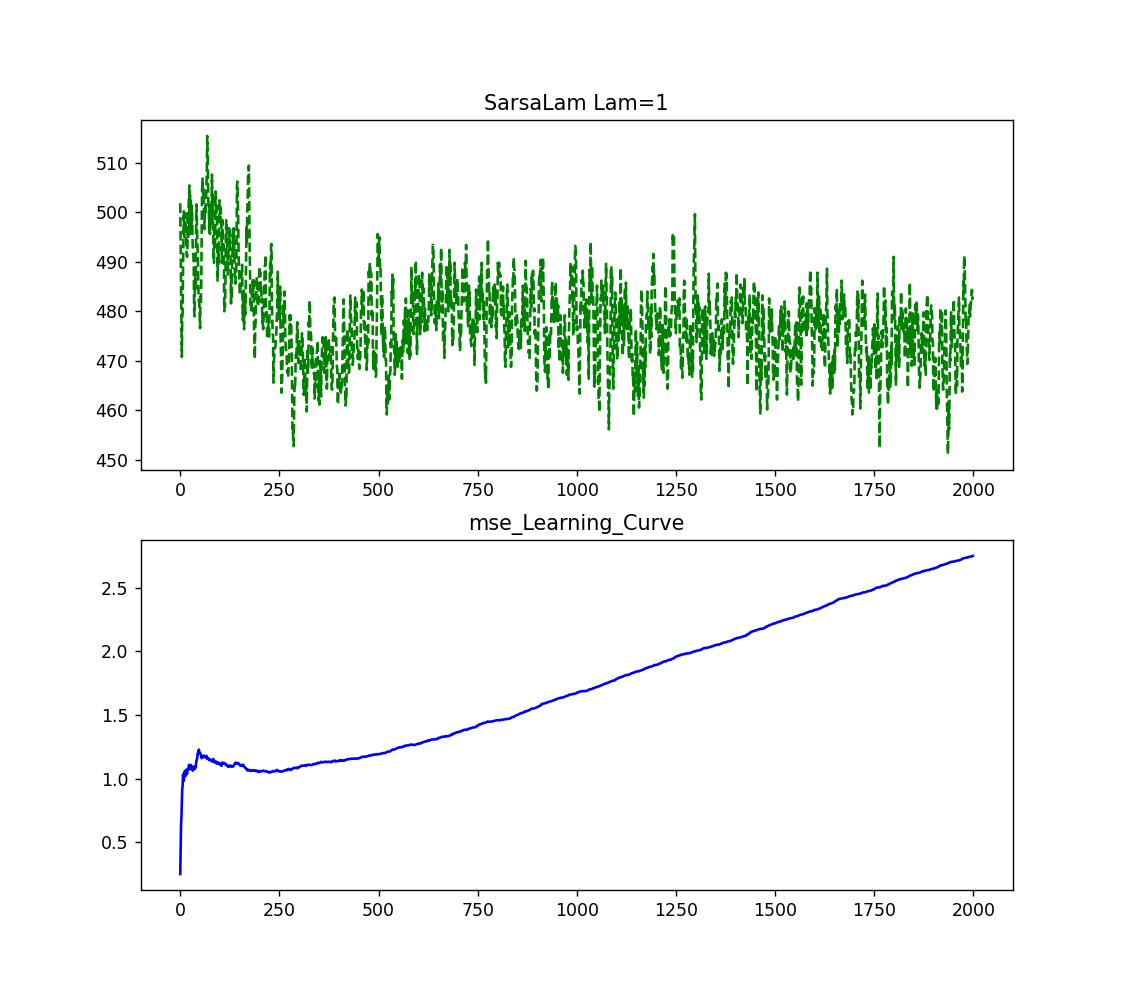

In [12]:
Q = np.zeros((21,10,2))
N = np.zeros((21,10,2))
n = 0
best = 0
win_history = []
mse_history = []
for i in trange(2000):
    mse_history.append(SarsaLam(100, 1, 100))
    n+=1000
    win_history.append(benchmark())
    if np.average(win_history[-10:]) > best:
        np.save("Best_Q_1",Q)
        best_i = i
        best = np.average(win_history[-10:])

rolling_wins =[]
roll = 5
i = 0
for i in range(len(win_history)):
    rolling_wins.append(np.average(win_history[i:i+roll]))
%matplotlib notebook
plt.figure(figsize=(9,8))
plt.subplot(2,1,1)
plt.plot(range(len(rolling_wins)), rolling_wins, 'g--')
plt.title("SarsaLam Lam=1")
plt.subplot(2,1,2)
plt.plot(range(len(mse_history)), mse_history, 'b')
plt.title("mse_Learning_Curve")
plt.savefig("Lam=1")
plt.show()

In [13]:
best_i

0

# Trained Agent Performance

In [14]:
Q = np.load("Best_Q_1.npy")

wins = 0
for i in range(1_00_000):
    curr = (np.random.choice(cards), np.random.choice(cards))
    act = np.argmax(Q[curr[1]-1][curr[0]-1])
    curr, rew, t = step(curr, act)
    while t == 0:
        act = act = np.argmax(Q[curr[1]-1][curr[0]-1])
        curr, rew, t = step(curr, act)
    if rew >= 0:
        wins += 1
print(wins)

49795


<IPython.core.display.Javascript object>


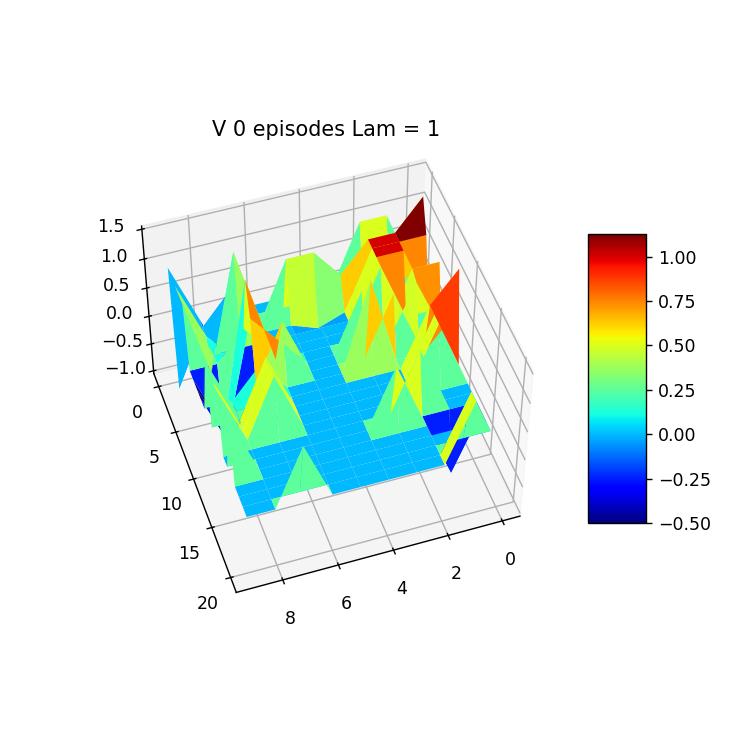

In [15]:
%matplotlib notebook
V = np.zeros((21, 10))
for j in range(21):
    for i in range(10):
        V[j][i] = np.max(Q[j][i])
X, Y = np.meshgrid(range(10), range(21))
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection = '3d')
surf = ax.plot_surface(X, Y, V, cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title(f"V {best_i} episodes Lam = 1")
plt.savefig(f"V {best_i} episodes Lam = 1")
plt.show()

<IPython.core.display.Javascript object>


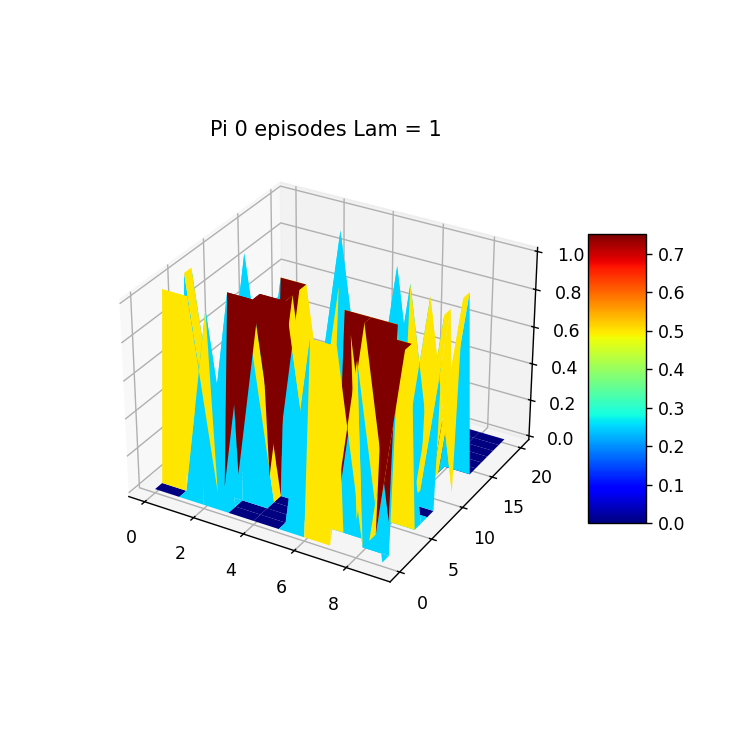

In [16]:
%matplotlib notebook
V = np.zeros((21, 10))
for j in range(21):
    for i in range(10):
        V[j][i] = np.argmax(Q[j][i])
X, Y = np.meshgrid(range(10), range(21))
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection = '3d')
surf = ax.plot_surface(X, Y, V, cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title(f"Pi {best_i} episodes Lam = 1")
plt.savefig(f"Pi {best_i} episodes Lam = 1")
plt.show()

In [17]:
os.chdir("/home/guest/Desktop/Om/Stuff/Reinforce/")